<div align=center>
		
<font size=5>
In the Name of God
<font/>
<p></p>
<br/>
<br/>
<font>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=cyan>
Artifical Intelligence - Dr. SamiEe
</font>
<br/>
<br/>

<hr/>
<font color=cyan>
Reinforcment Learning Practical Assignment
</font>
</div>

<ul>
  <li>Some cell's outputs have not been deleted. you can use these to make sure your implementation is correct.</li>
</ul>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agent in reinforcment learning environment. Our environment is a discrete-state env (and it is deterministic).
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [ ]:
%pip install gym==0.26
%pip install imageio imageio_ffmpeg
%pip install pygame
%pip install pyglet==1.5.1 
%apt install python-opengl
%apt install ffmpeg
%apt install xvfb
%pip install pyvirtualdisplay
%pip install 'gym[box2d]'

the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [1]:
from IPython.display import HTML
from base64 import b64encode
import imageio
import random
import numpy as np

## comment this part if your not using google colab
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
######################

def record_video_taxi_env(env, Qtable, out_directory, fps=1, random_action=False):
  images = []  
  done = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(6)  if random_action else np.argmax(Qtable[state][:])
    state, reward, done, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 500):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: Taxi Environment (35 + 10 Points)

In [10]:
import numpy as np
import numpy.typing as npt
import gym
import random
from tqdm import tqdm

In this exercise, we want to solve the Taxi-v3 environment. It is an environment, where we have a taxi, a passenger and a destination. taxi should go to the passenger's location, pick it up and then reach to destination and drop the passenger.
Please read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/taxi/)

**Question**  
Create an environment with the name `env` and print the number of states and actions.

In [3]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(6)
Discrete(500)


Let's run a random policy in this environement to get a better understanding of it.

In [5]:
record_video_taxi_env(env, None, 'taxi_random.mp4', fps=10, random_action=True)
show_video('taxi_random.mp4', video_width = 600)

/home/hirbod/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6c8d780] Warning: data is not aligned! This can lead to a speed loss


**Question**

Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  From the linked doc:

Actions:
* Move south
* Move north
* Move east
* Move west
* Pickup passenger
* Drop off passenger

State space:

There are 25 taxi positions. Passenger can have 5 locations: Red, Green, Yellow, Blue and in taxi. Destination can be either of 4 colors. This makes $25 \times 5 \times 4 = 500$ states.

Reward Function:
* -1 per step unless other reward is triggered.
* +20 delivering passenger.
* -10 executing “pickup” and “drop-off” actions illegally.

**Question**
 
Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [13]:
def initialize_q_table(state_space: int, action_space: int) -> npt.NDArray[np.float64]:
    return np.zeros((state_space, action_space))

In [14]:
Qtable = initialize_q_table(env.observation_space.n, env.action_space.n)
print(Qtable.shape)

(500, 6)


**Question**

Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [23]:
def epsilon_greedy_policy(Qtable: npt.NDArray[np.float64], state: int, epsilon: float):
    if random.random() < epsilon:
        env.action_space.sample()
    return np.argmax(Qtable[state,:])


**Question**
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [16]:
# Training parameters
n_training_episodes = 10000
n_eval_episodes = 100
learning_rate = 0.1           # Learning rate

# Environment parameters
max_steps = 1000               # Max steps per episode
gamma = 0.9                    # Discounting rate

# Exploration parameters
max_epsilon = 0.99           # Exploration probability at start
min_epsilon = 0.1              # Minimum exploration probability 
decay_rate = 0.99            # Exponential decay rate for exploration prob

**Question**

Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [31]:
# Mostly from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

def train(n_training_episodes: int, min_epsilon: float, max_epsilon: float, decay_rate: float, env: gym.Env, max_steps: int, Qtable: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    Qtable = Qtable.copy() # make a clone to forbid changes on passed array
    for _ in tqdm(range(n_training_episodes)):
        state, _ = env.reset()
        epsilon = max_epsilon
        done = False
        steps = 0
        while not done:
            # Main movement in environment
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            next_state, reward, done, _, _ = env.step(action) 
            old_value = Qtable[state, action]
            next_max = np.max(Qtable[next_state,:])
            new_value = (1 - learning_rate) * old_value + learning_rate * (reward + gamma * next_max)
            Qtable[state, action] = new_value
            state = next_state
            # Update epsilon
            epsilon = max(epsilon * decay_rate, min_epsilon)
            steps += 1
            # Check early end
            if steps >= max_steps:
                break
    return Qtable


We are now ready to train our agent.

In [32]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

100%|██████████| 10000/10000 [00:13<00:00, 769.22it/s]


Now, we will evaluate our agent. You don't need to write any code, just run the following cells as they are.

In [33]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    state, info = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward
        
      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [34]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}") # should be around 0.65

100%|██████████| 100/100 [00:00<00:00, 1235.47it/s]

Mean_reward=7.75 +/- 2.74


Now let's see how well our model is doing.

In [35]:
record_video_taxi_env(env, Qtable_trained, 'taxi_trained.mp4', fps=10)
show_video('taxi_trained.mp4', video_width = 600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x613a380] Warning: data is not aligned! This can lead to a speed loss


Next, we will take a look at the Q-function that was learned.

In [39]:
print(Qtable_trained)

[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.57563094 -3.50897372 -3.54343201 -3.50897372  1.62261467 -3.940399  ]
 [-1.81296575 -1.82093062 -1.8376156  -1.82093062  7.7147     -1.99      ]
 ...
 [-1.04661746 -1.04925109 -1.04661746 -1.1433191  -1.99       -1.99      ]
 [-2.52827906 -2.55011763 -2.52827906 -2.50558192 -2.9701     -2.9701    ]
 [-0.199      -0.199      -0.199      -0.01       -1.         -1.        ]]


**Question**

Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**
According to slides, it's this:
\begin{gather}
V_{\pi} (s) = \max_{a} Q_{\pi} (s, a)
\end{gather}


In [40]:
Vtable_trained = np.amax(Qtable_trained, axis=1)

Take a look at the value function

In [41]:
print(Vtable_trained)

[ 0.00000000e+00  1.62261467e+00  7.71470000e+00  2.91401630e+00
 -5.10905274e+00  0.00000000e+00 -5.12728674e+00 -3.61008341e+00
  9.18477125e-01 -2.94062088e+00  0.00000000e+00 -1.85805025e+00
 -4.10460356e+00 -2.53729069e+00 -4.06555560e+00  0.00000000e+00
  2.00000000e+01  2.91401630e+00  9.68300000e+00  4.34890700e+00
  0.00000000e+00  2.76866706e-01  5.78686529e+00  1.44495224e+00
 -4.44686588e+00  0.00000000e+00 -4.51385955e+00 -2.83245844e+00
 -1.52931471e-01 -3.40360763e+00  0.00000000e+00 -2.54656679e+00
 -3.14592975e+00 -1.76788436e+00 -3.38370614e+00  0.00000000e+00
 -1.00000000e-02 -2.50272396e+00 -1.08743587e+00 -2.17916757e+00
  0.00000000e+00 -4.04171029e+00 -7.99239776e-01 -3.27748099e+00
 -7.50389670e-01  0.00000000e+00 -7.27231618e-01  2.65430994e+00
 -7.12580133e-01 -3.96968929e+00  0.00000000e+00 -3.27382654e+00
 -2.56788075e+00 -6.99233321e-01 -2.74019199e+00  0.00000000e+00
 -1.74121289e+00  3.12575423e-01 -1.90734058e+00 -7.72553056e-01
  0.00000000e+00 -4.64765

**Question**  
Write a function to generate a visualization for the value function using a heatmap. In a few words, explain what you see.

I see absolutely nothing of value.

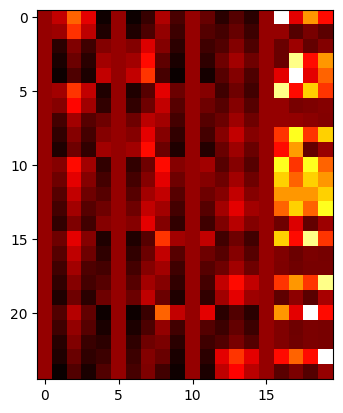

In [44]:
import matplotlib.pyplot as plt


def visualize(Vtable: npt.NDArray[np.float64]):
  """
  Visualize the value function
  :param Vtable: The value function
  """
  # I randomly used 25 × 20 reshape
  plt.imshow(Vtable.reshape((25, 20)), cmap='hot', interpolation='nearest')
  plt.show()
visualize(Vtable_trained)

**Question**  
Can we use a pure greedy policy for Q-learning? Explain.

Maybe in some cases the results converge. But it's a bad idea. At the very first of our search, we might take an action which leads us to a our goal. BUT from a bad (long or non rewarding) path.

So in some cases, we do random actions. This makes us discover better actions if we have missed them.